<a href="https://colab.research.google.com/github/Farouk96/Kaggle_competiition/blob/main/Copy_of_P8_01_documentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#IMPORT REQUIRED LIBRARIEs
from time import time
import numpy as np
import pandas as pd
import os
from re import search
import shutil
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import cv2

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense,Activation,Flatten, Conv2D, MaxPooling2D,Dropout

In [ ]:
!pip install tensorflow_addons
import tensorflow_addons as tfa

     |████████████████████████████████| 1.1 MB 11.6 MB/s 


#Data preparation

In [ ]:
#IMAGE PATH & DATAFRAME:
TRAIN_PATH = "/content/drive/MyDrive/ P8_kaggle_competition/train_images"
train_df = pd.read_csv("/content/drive/MyDrive/ P8_kaggle_competition/train.csv",sep=',')
train_df

,image,labels
0,800113bb65efe69e.jpg,healthy
1,8002cb321f8bfcdf.jpg,scab frog_eye_leaf_spot complex
2,80070f7fb5e2ccaa.jpg,scab
3,80077517781fb94f.jpg,scab
4,800cbf0ff87721f8.jpg,complex
...,...,...
18627,fffb900a92289a33.jpg,healthy
18628,fffc488fa4c0e80c.jpg,scab
18629,fffc94e092a59086.jpg,rust
18630,fffe105cf6808292.jpg,scab frog_eye_leaf_spot


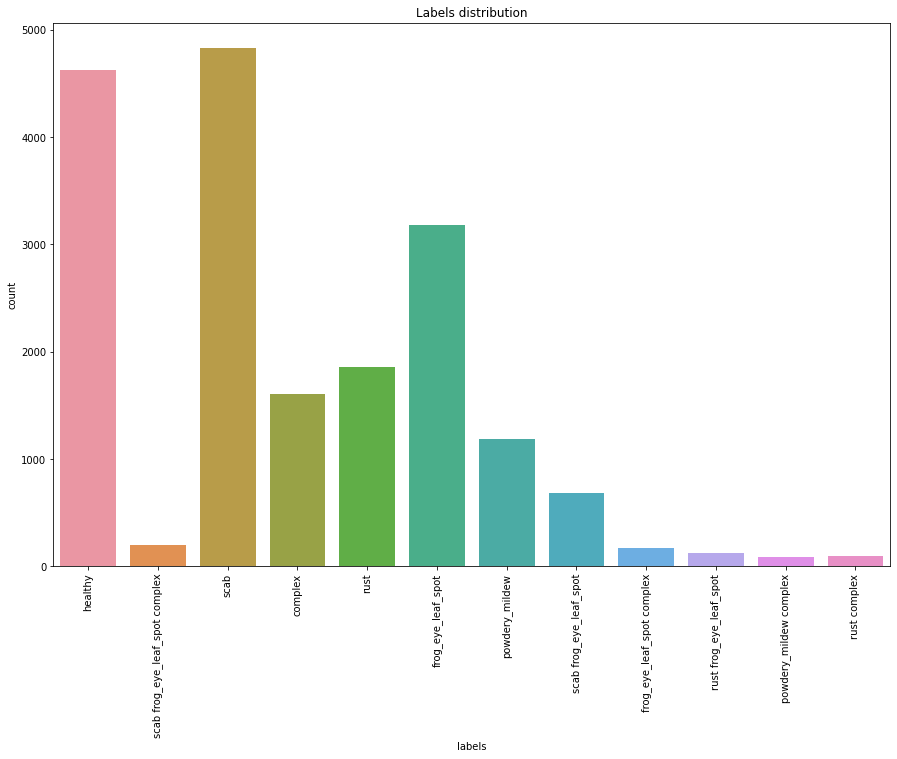

In [ ]:
#Labels distribution
plt.figure(figsize=(15,10))
sns.countplot(data=train_df,x='labels')
plt.xticks(rotation=90)
plt.title('Labels distribution')
plt.show()

In [ ]:
from os import listdir
from os.path import isfile, join

monRepertoire='/content/drive/MyDrive/ P8_kaggle_competition/train_images'
fichiers = [f for f in listdir(monRepertoire) if isfile(join(monRepertoire, f))]
fichiers

['c04632b533bba33d.jpg',
 'c03e65db32f086cd.jpg',
 'c0377614f870c35f.jpg',
 'c05a3720fd610edf.jpg',
 'c0702f17c4f8fb45.jpg',
 'c06d02d4ca4af5df.jpg',
 'c06c7a60b360b77e.jpg',
 'c08552de599f1c2f.jpg',
 'c08364e6716477fa.jpg',
 'c0816a962dceb76b.jpg',
 'c0853d6535f2d43e.jpg',
 'c08eb5c5b7953c98.jpg',
 'c0883b8e6e2ddf29.jpg',
 'c08e2b86b5bf70a3.jpg',
 'c09798cb9eb16639.jpg',
 'c09f21a433bf3758.jpg',
 'c09e35c7d027fa16.jpg',
 'c09927d183363cdf.jpg',
 'c0983fc02e27facb.jpg',
 'c09a3f8d684f1579.jpg',
 'c0a42dfd195dd331.jpg',
 'c0c063eb2afc3ab5.jpg',
 'c0c2202b0f7f7fe4.jpg',
 'c0bc431f5396b0f5.jpg',
 'c0bd68dad79507a2.jpg',
 'c0c73614ce4ee4ed.jpg',
 'c0cb3f1b38f8e0d4.jpg',
 'c0c8679f29e519bc.jpg',
 'c0cf8b9899d591b3.jpg',
 'c0c66a37fdf58061.jpg',
 'c0df29ce91d73950.jpg',
 'c0e027301fd757ad.jpg',
 'c0d91da6b3b891cd.jpg',
 'c0df0336b4707e65.jpg',
 'c0e00e1cff8f429f.jpg',
 'c0e6e21b32cde8f4.jpg',
 'c0e1616f4d439b9b.jpg',
 'c0e18cf07d1b2de9.jpg',
 'c0f1155cba5c13fc.jpg',
 'c0ef90ea018ffb1c.jpg',


In [ ]:
idx_list=[]
for i in train_df['image']:
  if i not in fichiers:
    dt= train_df[train_df['image']==i]
    train_df.drop(dt.index,axis=0,inplace=True)

In [ ]:
train_df.shape

(6227, 2)

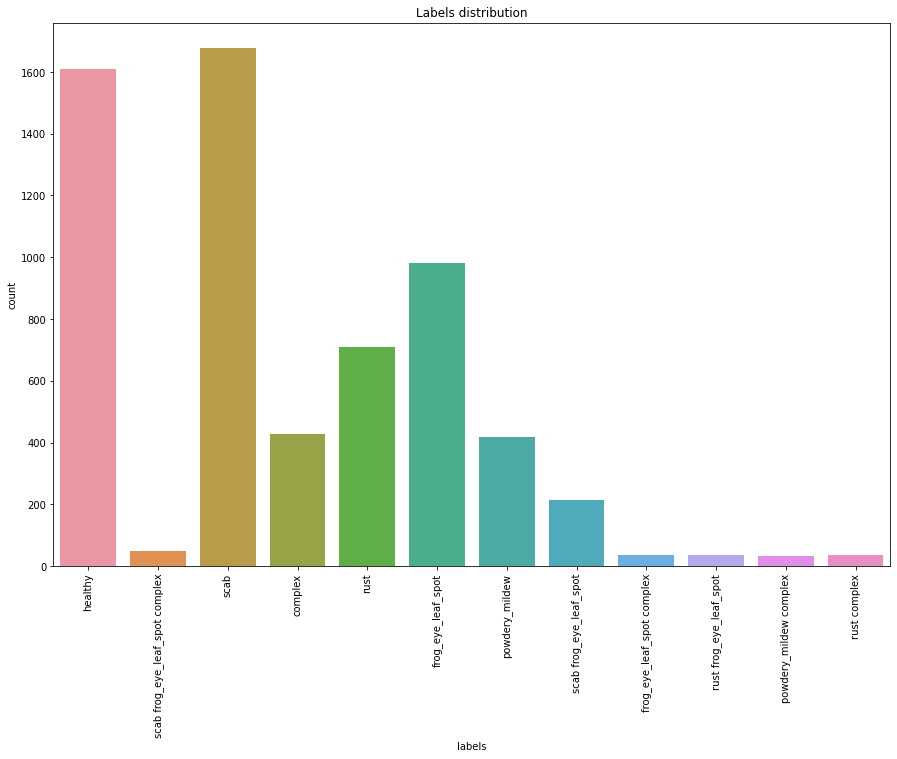

In [ ]:
#Labels distribution
plt.figure(figsize=(15,10))
sns.countplot(data=train_df,x='labels')
plt.xticks(rotation=90)
plt.title('Labels distribution')
plt.show()

In [ ]:
print("Number of unique labels: ",len(train_df['labels'].unique()))

Number of unique labels:  12


In [ ]:
# Use the Image Data Generator to import the images from the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1/255.,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split = 0.2,
    zoom_range = 0.2,
    shear_range = 0.2,
    vertical_flip = False)

In [ ]:
HEIGHT = 124
WIDTH=124
SEED = 143
BATCH_SIZE=32
train_ds = train_datagen.flow_from_dataframe(
    train_df,
    directory = TRAIN_PATH,
    x_col = "image",
    y_col = "labels",
    target_size = (HEIGHT,WIDTH),
    class_mode='categorical',
    batch_size = BATCH_SIZE,
    subset = "training",
    shuffle = True,
    seed = SEED,
    validate_filenames = False)

val_ds = train_datagen.flow_from_dataframe(
    train_df,
    directory = TRAIN_PATH,
    x_col = "image",
    y_col = "labels",
    target_size = (HEIGHT,WIDTH),
    class_mode='categorical',
    batch_size = BATCH_SIZE,
    subset = "validation",
    shuffle = True,
    seed = SEED,
    validate_filenames = False
)

Found 4982 non-validated image filenames belonging to 12 classes.
Found 1245 non-validated image filenames belonging to 12 classes.


#CNN from scratch

In [ ]:
model=Sequential()
model.add(Conv2D(64,(3,3),activation='relu',padding='same',input_shape=(HEIGHT,WIDTH,3)))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(64,(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(64,(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(128,(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(2,2))
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(12,activation='sigmoid'))

# Compile the Model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics = [tfa.metrics.F1Score(num_classes = 12,average = "macro",name = "f1_score")])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 124, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 62, 62, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 62, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 31, 31, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 31, 31, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 15, 15, 64)       0

In [ ]:
# Compile the Model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics = [tfa.metrics.F1Score(num_classes = 12,average = "macro",name = "f1_score")])

In [ ]:
file_path= '/content/drive/MyDrive/ P8_kaggle_competition/Best_model_cnn.h5'

checkpoint=ModelCheckpoint(file_path,
                          monitor="val_f1_score",
                          mode='max',
                          save_best_only=True,
                          verbose=1)
earlystop=EarlyStopping(monitor="val_f1_score",mode='max',
                       patience=5,
                       verbose=1,
                       restore_best_weights=True)

callbacks=[checkpoint,earlystop]

In [ ]:
t0 = time()

epochs = 60

model_history=model.fit(train_ds,validation_data=val_ds,
                                 epochs= epochs,
                                 steps_per_epoch=train_ds.samples//128,
                                 validation_steps=val_ds.samples//128,
                                 callbacks=callbacks)


print("Done in %0.3fs." % (time() - t0))

Epoch 1/60
38/38 [==============================] - ETA: 0s - loss: 1.9678 - f1_score: 0.0715
Epoch 00001: val_f1_score improved from -inf to 0.02913, saving model to /content/drive/MyDrive/ P8_kaggle_competition/Best_model_cnn.h5
38/38 [==============================] - 230s 6s/step - loss: 1.9678 - f1_score: 0.0715 - val_loss: 1.8913 - val_f1_score: 0.0291
Epoch 2/60
38/38 [==============================] - ETA: 0s - loss: 1.8851 - f1_score: 0.0569
Epoch 00002: val_f1_score improved from 0.02913 to 0.03327, saving model to /content/drive/MyDrive/ P8_kaggle_competition/Best_model_cnn.h5
38/38 [==============================] - 206s 5s/step - loss: 1.8851 - f1_score: 0.0569 - val_loss: 1.8740 - val_f1_score: 0.0333
Epoch 3/60
38/38 [==============================] - ETA: 0s - loss: 1.8414 - f1_score: 0.0686
Epoch 00003: val_f1_score improved from 0.03327 to 0.10293, saving model to /content/drive/MyDrive/ P8_kaggle_competition/Best_model_cnn.h5
38/38 [==============================] - 

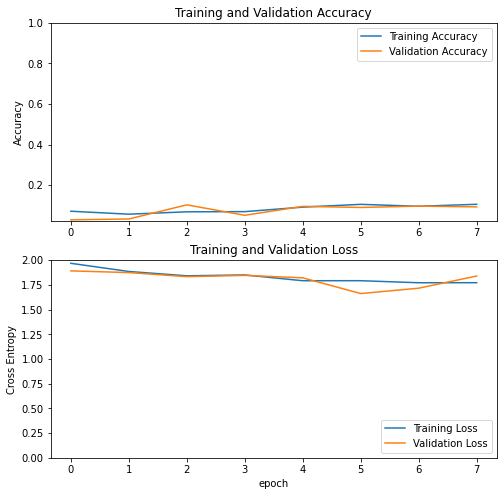

In [ ]:
acc = model_history.history['f1_score']
val_acc = model_history.history['val_f1_score']

loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='upper right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='lower right')
plt.ylabel('Cross Entropy')
plt.ylim([0,2.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

#Transfer learning with inceptionV3

In [ ]:
from  tensorflow.keras.applications import InceptionV3

In [ ]:
#initialise base model
IMG_SHAPE = (124, 124, 3)

base_model=  InceptionV3(
    weights='imagenet',
    input_shape= IMG_SHAPE,
    include_top=False)

87924736/87910968 [==============================] - 1s 0us/step


In [ ]:
base_model.trainable = False
model = tf.keras.Sequential()
model.add(base_model)
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dense(320, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(12, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2, 2, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 320)               655680    
                                                                 
 dropout (Dropout)           (None, 320)               0         
                                                                 
 dense_1 (Dense)             (None, 12)                3852      
                                                                 
Total params: 22,462,316
Trainable params: 659,532
Non-trainable params: 21,802,784
______________________________________

In [ ]:
# Compile the Model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics = [tfa.metrics.F1Score(num_classes = 12,average = "macro",name = "f1_score")])

In [ ]:
file_path= '/content/drive/MyDrive/ P8_kaggle_competition/Best_basemodel_inceptionV3.h5'

checkpoint=ModelCheckpoint(file_path,
                          monitor="val_f1_score",
                          mode='max',
                          save_best_only=True,
                          verbose=1)
earlystop=EarlyStopping(monitor="val_f1_score",mode='max',
                       patience=5,
                       verbose=1,
                       restore_best_weights=True)

callbacks=[checkpoint,earlystop]

In [ ]:
t0 = time()

epochs = 20

model_history= model.fit(train_ds,validation_data=val_ds,
                         steps_per_epoch=train_ds.samples//128,
                                 validation_steps=val_ds.samples//128,
                                 epochs= epochs,
                                 callbacks=callbacks)


print("Done in %0.3fs." % (time() - t0))

Epoch 1/20
38/38 [==============================] - ETA: 0s - loss: 2.5604 - f1_score: 0.1175 
Epoch 00001: val_f1_score improved from -inf to 0.09451, saving model to /content/drive/MyDrive/ P8_kaggle_competition/Best_basemodel_inceptionV3.h5
38/38 [==============================] - 710s 18s/step - loss: 2.5604 - f1_score: 0.1175 - val_loss: 1.9593 - val_f1_score: 0.0945
Epoch 2/20
38/38 [==============================] - ETA: 0s - loss: 1.7633 - f1_score: 0.1360 
Epoch 00002: val_f1_score improved from 0.09451 to 0.16748, saving model to /content/drive/MyDrive/ P8_kaggle_competition/Best_basemodel_inceptionV3.h5
38/38 [==============================] - 575s 15s/step - loss: 1.7633 - f1_score: 0.1360 - val_loss: 1.6097 - val_f1_score: 0.1675
Epoch 3/20
38/38 [==============================] - ETA: 0s - loss: 1.6765 - f1_score: 0.1775 
Epoch 00003: val_f1_score improved from 0.16748 to 0.20068, saving model to /content/drive/MyDrive/ P8_kaggle_competition/Best_basemodel_inceptionV3.h5


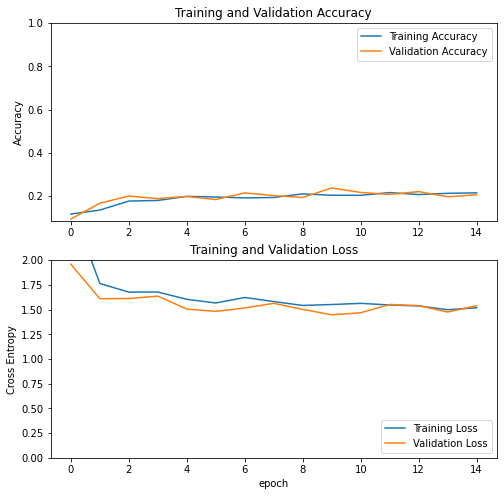

In [ ]:
acc = model_history.history['f1_score']
val_acc = model_history.history['val_f1_score']

loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='upper right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='lower right')
plt.ylabel('Cross Entropy')
plt.ylim([0,2.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

##Fine_tunning

In [ ]:
base_model.trainable = True

In [ ]:
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  311


In [ ]:
fine_tune_at = 200

# Freeze all the layers before the 'fine_tune_at' layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [ ]:
# Compile the Model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001/10),
    loss='categorical_crossentropy',
    metrics = [tfa.metrics.F1Score(num_classes = 12,average = "macro",name = "f1_score")])

In [ ]:
file_path= '/content/drive/MyDrive/ P8_kaggle_competition/Best_model_inceptionV3.h5'

checkpoint=ModelCheckpoint(file_path,
                          monitor="val_f1_score",
                          mode='max',
                          save_best_only=True,
                          verbose=1)
earlystop=EarlyStopping(monitor="val_f1_score",mode='max',
                       patience=5,
                       verbose=1,
                       restore_best_weights=True)

callbacks=[checkpoint,earlystop]

In [ ]:
t0 = time()

fine_tune_epochs = 40
total_epochs =  epochs + fine_tune_epochs

model_history_fine = model.fit(train_ds,validation_data=val_ds,
                         steps_per_epoch=train_ds.samples//128,
                                 validation_steps=val_ds.samples//128,
                                 epochs= total_epochs,
                         initial_epoch=model_history.epoch[-1],
                                 callbacks=callbacks)


print("Done in %0.3fs." % (time() - t0))

Epoch 15/60
38/38 [==============================] - ETA: 0s - loss: 1.8136 - f1_score: 0.1516
Epoch 00015: val_f1_score improved from -inf to 0.14638, saving model to /content/drive/MyDrive/ P8_kaggle_competition/Best_model_inceptionV3.h5
38/38 [==============================] - 251s 6s/step - loss: 1.8136 - f1_score: 0.1516 - val_loss: 1.9690 - val_f1_score: 0.1464
Epoch 16/60
38/38 [==============================] - ETA: 0s - loss: 1.4828 - f1_score: 0.2057
Epoch 00016: val_f1_score improved from 0.14638 to 0.20353, saving model to /content/drive/MyDrive/ P8_kaggle_competition/Best_model_inceptionV3.h5
38/38 [==============================] - 242s 6s/step - loss: 1.4828 - f1_score: 0.2057 - val_loss: 1.5683 - val_f1_score: 0.2035
Epoch 17/60
38/38 [==============================] - ETA: 0s - loss: 1.4802 - f1_score: 0.2181
Epoch 00017: val_f1_score improved from 0.20353 to 0.23792, saving model to /content/drive/MyDrive/ P8_kaggle_competition/Best_model_inceptionV3.h5
38/38 [=======

In [ ]:
acc += model_history_fine.history['f1_score']
val_acc += model_history_fine.history['val_f1_score']

loss += model_history_fine.history['loss']
val_loss += model_history_fine.history['val_loss']

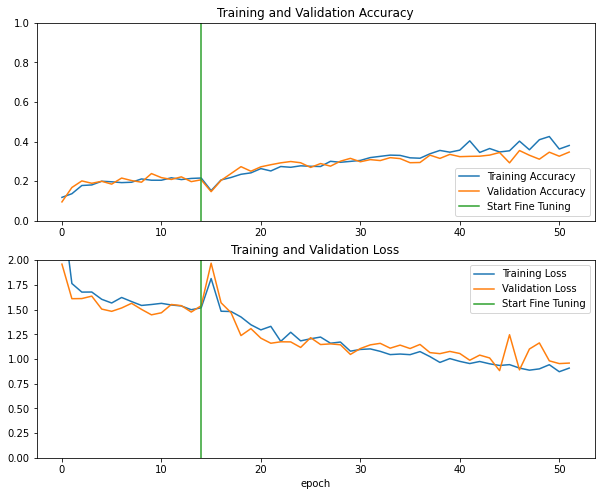

In [ ]:
plt.figure(figsize=(10, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([model_history.epoch[-1],model_history.epoch[-1]],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 2.0])
plt.plot([model_history.epoch[-1],model_history.epoch[-1]],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

#Transfer learning with MobileNetV2

In [ ]:
from  tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

In [ ]:
#initialise base model
IMG_SHAPE = (124, 124, 3)

base_model=  MobileNetV2(
    weights='imagenet',
    input_shape= IMG_SHAPE,
    include_top=False)

9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
base_model.trainable = False
model = tf.keras.Sequential()
model.add(base_model)
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dense(320, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(12, activation='sigmoid'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 4, 4, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 320)               409920    
                                                                 
 dropout_2 (Dropout)         (None, 320)               0         
                                                                 
 dense_5 (Dense)             (None, 12)                3852      
                                                                 
Total params: 2,671,756
Trainable params: 413,772
Non-

In [ ]:
# Compile the Model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics = [tfa.metrics.F1Score(num_classes = 12,average = "macro",name = "f1_score")])

In [ ]:
file_path= '/content/drive/MyDrive/ P8_kaggle_competition/Best_basemodel_mobilenetV2.h5'

checkpoint=ModelCheckpoint(file_path,
                          monitor="val_f1_score",
                          mode='max',
                          save_best_only=True,
                          verbose=1)
earlystop=EarlyStopping(monitor="val_f1_score",mode='max',
                       patience=5,
                       verbose=1,
                       restore_best_weights=True)

callbacks=[checkpoint,earlystop]

In [ ]:
t0 = time()

epochs = 20

model_history= model.fit(train_ds,validation_data=val_ds,
                         steps_per_epoch=train_ds.samples//128,
                                 validation_steps=val_ds.samples//128,
                                 epochs= epochs,
                                 callbacks=callbacks)


print("Done in %0.3fs." % (time() - t0))

Epoch 1/20
38/38 [==============================] - ETA: 0s - loss: 1.9650 - f1_score: 0.1679
Epoch 00001: val_f1_score improved from -inf to 0.24332, saving model to /content/drive/MyDrive/ P8_kaggle_competition/Best_basemodel_mobilenetV2.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


38/38 [==============================] - 211s 6s/step - loss: 1.9650 - f1_score: 0.1679 - val_loss: 1.5585 - val_f1_score: 0.2433
Epoch 2/20
38/38 [==============================] - ETA: 0s - loss: 1.5900 - f1_score: 0.2114
Epoch 00002: val_f1_score did not improve from 0.24332
38/38 [==============================] - 199s 5s/step - loss: 1.5900 - f1_score: 0.2114 - val_loss: 1.4273 - val_f1_score: 0.2422
Epoch 3/20
38/38 [==============================] - ETA: 0s - loss: 1.4536 - f1_score: 0.2416
Epoch 00003: val_f1_score improved from 0.24332 to 0.26448, saving model to /content/drive/MyDrive/ P8_kaggle_competition/Best_basemodel_mobilenetV2.h5
38/38 [==============================] - 201s 5s/step - loss: 1.4536 - f1_score: 0.2416 - val_loss: 1.3100 - val_f1_score: 0.2645
Epoch 4/20
38/38 [==============================] - ETA: 0s - loss: 1.3697 - f1_score: 0.2572
Epoch 00004: val_f1_score did not improve from 0.26448
38/38 [==============================] - 200s 5s/step - loss: 1.36

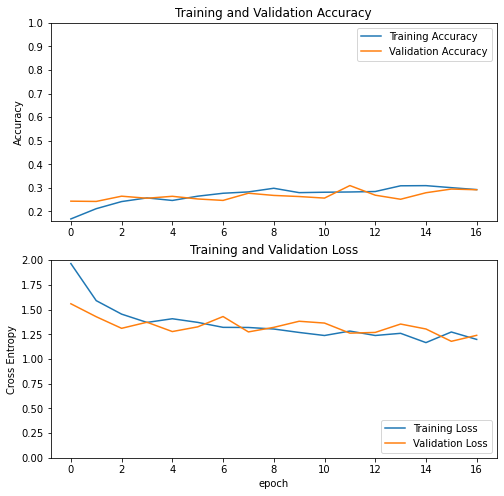

In [ ]:
acc = model_history.history['f1_score']
val_acc = model_history.history['val_f1_score']

loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='upper right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='lower right')
plt.ylabel('Cross Entropy')
plt.ylim([0,2.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

##Fine-tunning

In [ ]:
base_model.trainable = True

In [ ]:
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  154


In [ ]:
fine_tune_at = 100

# Freeze all the layers before the 'fine_tune_at' layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [ ]:
file_path= '/content/drive/MyDrive/ P8_kaggle_competition/Best_model_mobilenetV2.h5'

checkpoint=ModelCheckpoint(file_path,
                          monitor="val_f1_score",
                          mode='max',
                          save_best_only=True,
                          verbose=1)
earlystop=EarlyStopping(monitor="val_f1_score",mode='max',
                       patience=5,
                       verbose=1,
                       restore_best_weights=True)

callbacks=[checkpoint,earlystop]

In [ ]:
# Compile the Model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics = [tfa.metrics.F1Score(num_classes = 12,average = "macro",name = "f1_score")])

In [ ]:
t0 = time()

fine_tune_epochs = 40
total_epochs =  20 + fine_tune_epochs

model_history_fine = model.fit(train_ds,validation_data=val_ds,
                         steps_per_epoch=train_ds.samples//128,
                                 validation_steps=val_ds.samples//128,
                                 epochs= total_epochs,
                         initial_epoch=19, #model_history.epoch[-1],
                                 callbacks=callbacks)


print("Done in %0.3fs." % (time() - t0))

Epoch 20/60
38/38 [==============================] - ETA: 0s - loss: 1.5301 - f1_score: 0.2378
Epoch 00020: val_f1_score improved from -inf to 0.07942, saving model to /content/drive/MyDrive/ P8_kaggle_competition/Best_model_mobilenetV2.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


38/38 [==============================] - 211s 5s/step - loss: 1.5301 - f1_score: 0.2378 - val_loss: 9.6702 - val_f1_score: 0.0794
Epoch 21/60
38/38 [==============================] - ETA: 0s - loss: 1.2392 - f1_score: 0.2775
Epoch 00021: val_f1_score improved from 0.07942 to 0.09944, saving model to /content/drive/MyDrive/ P8_kaggle_competition/Best_model_mobilenetV2.h5
38/38 [==============================] - 202s 5s/step - loss: 1.2392 - f1_score: 0.2775 - val_loss: 9.9668 - val_f1_score: 0.0994
Epoch 22/60
38/38 [==============================] - ETA: 0s - loss: 1.1670 - f1_score: 0.3047
Epoch 00022: val_f1_score did not improve from 0.09944
38/38 [==============================] - 201s 5s/step - loss: 1.1670 - f1_score: 0.3047 - val_loss: 10.1744 - val_f1_score: 0.0830
Epoch 23/60
38/38 [==============================] - ETA: 0s - loss: 1.1101 - f1_score: 0.3169
Epoch 00023: val_f1_score improved from 0.09944 to 0.19587, saving model to /content/drive/MyDrive/ P8_kaggle_competition

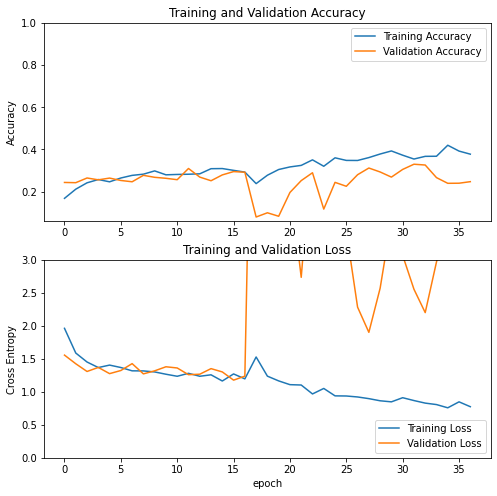

In [ ]:
acc += model_history_fine.history['f1_score']
val_acc += model_history_fine.history['val_f1_score']

loss += model_history_fine.history['loss']
val_loss += model_history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='upper right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='lower right')
plt.ylabel('Cross Entropy')
plt.ylim([0,3.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

#Evaluation performance

##InceptionV3

In [ ]:
model.load_weights("/content/drive/MyDrive/ P8_kaggle_competition/Best_model_inceptionV3.h5")
loss, accuracy = model.evaluate(val_ds)
print('Valid accuracy :', round(accuracy, 3))
print('Valid loss :', round(loss, 3))

39/39 [==============================] - 682s 18s/step - loss: 1.0929 - f1_score: 0.3265
Valid accuracy : 0.327
Valid loss : 1.093
